In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing libraries
import os
from osgeo import gdal, gdalconst
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Don't forget to change to your own path in your google drive
path_to_landsat_data = '/content/drive/MyDrive/Project Geog371/landsat_data'

In [ ]:
landsat_id = 'LC09_L1TP_015034_20241105_20241105_02_T1'

TOA Reflectance 

In [ ]:
# This is an example how to convert DN for band 2 to TOA reflectance
band = 'B8'

print(f'Processing band {band} for Landsat scene {landsat_id}')
# First, read Landsat metadata: sun elevation angle and MULT/ADD for the band
fname_meta_landsat = f'{landsat_id}_MTL.txt'
fmeta_landsat = open(os.path.join(path_to_landsat_data, fname_meta_landsat), 'r')
tmp = fmeta_landsat.read()

# Searching sun zenith angle
param = 'SUN_ELEVATION'
i = tmp.find(f'{param} = ') + len(f'{param} = ')
SUN_ELEVATION = float(tmp[i:i+11])
print(f'SUN_ELEVATION={SUN_ELEVATION}')

# MULT/ADD params
param = f'REFLECTANCE_MULT_BAND_{band[1]}'
i = tmp.find(f'{param} = ') + len(f'{param} = ')
REFLECTANCE_MULT_BAND = float(tmp[i:i+11])
print(f'REFLECTANCE_MULT_BAND={REFLECTANCE_MULT_BAND}')

param = f'REFLECTANCE_ADD_BAND_{band[1]}'
i = tmp.find(f'{param} = ') + len(f'{param} = ')
REFLECTANCE_ADD_BAND = float(tmp[i:i+11])
print(f'REFLECTANCE_ADD_BAND={REFLECTANCE_ADD_BAND}')

# Reading raster data corresponding to the band
fname_band = f'{landsat_id}_{band}.TIF'
# YOUR COMMENT: Read the raster file with band 2 as an instance of the Dataset class
in_dataset = gdal.Open(os.path.join(path_to_landsat_data, fname_band))
# YOUR COMMENT: Gets the number of columns
x_size = in_dataset.RasterXSize
# YOUR COMMENT: Gets the number of rows
y_size = in_dataset.RasterYSize
# YOUR COMMENT: Gets the projection of the raster in WKT format
projection = in_dataset.GetProjectionRef()
# YOUR COMMENT: Convert pixel coordinates to georeference coordinates
geo_transform = in_dataset.GetGeoTransform()
# YOUR COMMENT: Converts band 1 as numpy array and makes sure that the elements are of float32 format
array = np.array(in_dataset.GetRasterBand(1).ReadAsArray()).astype(np.float32)

# Writing raster: preparing for writing TOA
# YOUR COMMENT: What type of file we want to create/write to
outfile_driver = gdal.GetDriverByName('GTiff')
outfile_name = f'{landsat_id}_{band}_TOA.TIF'
# YOUR COMMENT: Specifies the data type of the outfile dataset to Int16 which is less expensive in terms of byte storage
outfile_dtype = gdalconst.GDT_Int16
# YOUR COMMENT: Compress the file
outfile_options = ['COMPRESS=NONE']
# YOUR COMMENT: Create the outfile dataset driver with only 1 band
outfile_dataset = outfile_driver.Create(os.path.join(path_to_landsat_data, outfile_name), x_size, y_size, 1,
                                   outfile_dtype, outfile_options)
# YOUR COMMENT: Sets the projection using the SetProjection setter with the projection derived from the Getter GetProjectionRef()
outfile_dataset.SetProjection(projection)
# YOUR COMMENT: Sets the Geotransform to the outfile_dataset
outfile_dataset.SetGeoTransform(geo_transform)
# YOUR COMMENT: Applies calibration parameters to the array
calibrated_array = array * REFLECTANCE_MULT_BAND + REFLECTANCE_ADD_BAND
# YOUR COMMENT: Applies the SUN_ELEVATION and converts it radians
calibrated_array = calibrated_array / np.sin(SUN_ELEVATION * np.pi / 180.)
# YOUR COMMENT: TOA reflectance values range from 0 - 1 but we scale this value by 10000 to save space since we wont have to store decimal values
calibrated_array = 10000 * calibrated_array
# YOUR COMMENT: Everywhere where the input is 0 assign to -9999 since 0 is a no data value and not a pixel with the 0 value and everything else is just the values in the calibrated array
calibrated_array = np.where(array == 0, -9999, calibrated_array)
# YOUR COMMENT: Write the array to the outfile dataset
outfile_dataset.GetRasterBand(1).WriteArray(calibrated_array)
# YOUR COMMENT: Set the outfile no data values
outfile_dataset.GetRasterBand(1).SetNoDataValue(-9999)

outfile_dataset = None
in_dataset = None

print(f'Processing complete!')

NameError: name 'landsat_id' is not defined

GET SHAPE OF TOA files

In [ ]:
# Function to get the shape of a band in a TIFF file
def get_band_shape(file_path):
    dataset = gdal.Open(file_path)
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize
    dataset = None
    return (y_size, x_size)

# File paths for the original TOA TIFF files
original_files = [
    '/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B2_TOA.TIF',
    '/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B3_TOA.TIF',
    '/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B4_TOA.TIF',
    '/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B8_TOA.TIF'
]

# Get and print the shapes of the original TOA TIFF files
for file_path in original_files:
    shape = get_band_shape(file_path)
    print(f"Shape of {file_path}: {shape}")

Shape of /content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B2_TOA.TIF: (7961, 7841)
Shape of /content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B3_TOA.TIF: (7961, 7841)
Shape of /content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B4_TOA.TIF: (7961, 7841)
Shape of /content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B8_TOA.TIF: (15921, 15681)


RESAMPLE 

In [ ]:
# Function to resample a band to a target resolution
def resample_band(input_file, output_file, target_resolution):
    # Open the input dataset
    input_dataset = gdal.Open(input_file)

    # Get the original geotransform
    original_geo_transform = input_dataset.GetGeoTransform()
    original_resolution = (original_geo_transform[1], original_geo_transform[5]) # gets original x and y pixel size

    # Get the original dimensions
    original_x_size = input_dataset.RasterXSize
    original_y_size = input_dataset.RasterYSize

    # Calculate the new dimensions based on the target resolution
    new_x_size = int(original_x_size * abs(original_resolution[0] / target_resolution))
    new_y_size = int(original_y_size * abs(original_resolution[1] / target_resolution))

    # Create the output dataset with the new dimensions
    driver = gdal.GetDriverByName('GTiff')
    output_dataset = driver.Create(output_file, new_x_size, new_y_size, 1, gdal.GDT_Float32)

    # Set the new geotransform with the target resolution
    new_geo_transform = list(original_geo_transform)
    new_geo_transform[1] = target_resolution # changes pixel size in x direction
    new_geo_transform[5] = -target_resolution # changes pixel size in y direction
    output_dataset.SetGeoTransform(new_geo_transform)

    # Set the projection of the output dataset to match the input dataset
    output_dataset.SetProjection(input_dataset.GetProjection())

    # Perform the resampling using bilinear interpolation
    gdal.ReprojectImage(input_dataset, output_dataset, None, None, gdal.GRA_Bilinear)

    # Print the shape of the resampled band
    print(f"Shape of resampled band ({input_file}): ({new_y_size}, {new_x_size})")

    # Close the datasets
    input_dataset = None
    output_dataset = None

# File paths for the input and output files
input_files = [
    '/content/drive/MyDrive/geog371shared/subsets/subset_band2_TOA.tif',
    '/content/drive/MyDrive/geog371shared/subsets/subset_band3_TOA.tif',
    '/content/drive/MyDrive/geog371shared/subsets/subset_band4_TOA.tif',
    '/content/drive/MyDrive/geog371shared/subsets/subset_band8_TOA.tif'
]
output_files = [
    '/content/drive/MyDrive/geog371shared/subsets/resampled/subset_band2_TOA_resampled.TIF',
    '/content/drive/MyDrive/geog371shared/subsets/resampled/subset_band3_TOA_resampled.TIF',
    '/content/drive/MyDrive/geog371shared/subsets/resampled/subset_band4_TOA_resampled.TIF',
    '/content/drive/MyDrive/geog371shared/subsets/resampled/subset_band8_TOA_resampled.TIF'
]

target_resolution = 15  # Target resolution in meters

# Loop through each input file and resample it to the target resolution
for input_file, output_file in zip(input_files, output_files):
    resample_band(input_file, output_file, target_resolution)

print("Resampling complete!")

Shape of resampled band (/content/drive/MyDrive/geog371shared/subsets/subset_band2_TOA.tif): (1000, 1000)
Shape of resampled band (/content/drive/MyDrive/geog371shared/subsets/subset_band3_TOA.tif): (1000, 1000)
Shape of resampled band (/content/drive/MyDrive/geog371shared/subsets/subset_band4_TOA.tif): (1000, 1000)
Shape of resampled band (/content/drive/MyDrive/geog371shared/subsets/subset_band8_TOA.tif): (500, 500)
Resampling complete!


GET SHAPE OF RESAMPLED TOA files

In [ ]:
# Function to get the shape of a band in a TIFF file
def get_band_shape(file_path):
    dataset = gdal.Open(file_path)
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize
    dataset = None
    return (y_size, x_size)

# File paths for the original TOA TIFF files
original_files = [
    '/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B2_TOA_resampled.TIF',
    '/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B3_TOA_resampled.TIF',
    '/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B4_TOA_resampled.TIF',
    '/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B8_TOA.TIF'
]

# Get and print the shapes of the original TOA TIFF files
for file_path in original_files:
    shape = get_band_shape(file_path)
    print(f"Shape of {file_path}: {shape}")

Shape of /content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B2_TOA_resampled.TIF: (15922, 15682)
Shape of /content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B3_TOA_resampled.TIF: (15922, 15682)
Shape of /content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B4_TOA_resampled.TIF: (15922, 15682)
Shape of /content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B8_TOA.TIF: (15921, 15681)


CREATE SUBSETS FOR RESAMPLED TOA FILES AND BAND 8

In [ ]:
subset_coords = (6000, 6000, 6500, 6500)

# Read the resampled TOA reflectance data
ds_B2_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B2_TOA_resampled.TIF')
ds_B3_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B3_TOA_resampled.TIF')
ds_B4_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B4_TOA_resampled.TIF')
ds_B8_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/Data/LC09_L1TP_015034_20241105_20241105_02_T1_B8_TOA.TIF')
# Convert subset coordinates to pixel coordinates
x_offset = subset_coords[0]
y_offset = subset_coords[1]
x_size = subset_coords[2] - subset_coords[0]
y_size = subset_coords[3] - subset_coords[1]

# Read the subset data
band2 = ds_B2_TOA.GetRasterBand(1).ReadAsArray(x_offset, y_offset, x_size, y_size).astype(np.float32)
band3 = ds_B3_TOA.GetRasterBand(1).ReadAsArray(x_offset, y_offset, x_size, y_size).astype(np.float32)
band4 = ds_B4_TOA.GetRasterBand(1).ReadAsArray(x_offset, y_offset, x_size, y_size).astype(np.float32)
band8 = ds_B8_TOA.GetRasterBand(1).ReadAsArray(x_offset, y_offset, x_size, y_size).astype(np.float32)

# Print the shapes of each band
print(f"Shape of band 2: {band2.shape}")
print(f"Shape of band 3: {band3.shape}")
print(f"Shape of band 4: {band4.shape}")
print(f"Shape of band 8: {band8.shape}")

# Create outfile driver
driver = gdal.GetDriverByName('GTiff')

# Declare outfile parameters
xsize = x_size
ysize = y_size
gdal_type = gdal.GDT_Float32

# Create outfile datasets
output_file_band2 = os.path.join('/content/drive/MyDrive/geog371shared/subsets', 'subset_resampled_band2_TOA.tif')
output_file_band3 = os.path.join('/content/drive/MyDrive/geog371shared/subsets', 'subset_resampled_band3_TOA.tif')
output_file_band4 = os.path.join('/content/drive/MyDrive/geog371shared/subsets', 'subset_resampled_band4_TOA.tif')
output_file_band8 = os.path.join('/content/drive/MyDrive/geog371shared/subsets', 'subset_band8_TOA.tif')

out_dataset_band2 = driver.Create(output_file_band2, xsize, ysize, 1, gdal_type)
out_dataset_band3 = driver.Create(output_file_band3, xsize, ysize, 1, gdal_type)
out_dataset_band4 = driver.Create(output_file_band4, xsize, ysize, 1, gdal_type)
out_dataset_band8 = driver.Create(output_file_band8, xsize, ysize, 1, gdal_type)
# Write the subset data to the output datasets
out_dataset_band2.GetRasterBand(1).WriteArray(band2)
out_dataset_band3.GetRasterBand(1).WriteArray(band3)
out_dataset_band4.GetRasterBand(1).WriteArray(band4)
out_dataset_band8.GetRasterBand(1).WriteArray(band8)

out_dataset_band2.SetProjection(ds_B2_TOA.GetProjection())
out_dataset_band2.SetGeoTransform(ds_B2_TOA.GetGeoTransform())

out_dataset_band3.SetProjection(ds_B3_TOA.GetProjection())
out_dataset_band3.SetGeoTransform(ds_B3_TOA.GetGeoTransform())

out_dataset_band4.SetProjection(ds_B4_TOA.GetProjection())
out_dataset_band4.SetGeoTransform(ds_B4_TOA.GetGeoTransform())

out_dataset_band8.SetProjection(ds_B8_TOA.GetProjection())
out_dataset_band8.SetGeoTransform(ds_B8_TOA.GetGeoTransform())
# Close the datasets
out_dataset_band2 = None
out_dataset_band3 = None
out_dataset_band4 = None
out_dataset_band8 = None
ds_B2_TOA = None
ds_B3_TOA = None
ds_B4_TOA = None
ds_B8_TOA = None

Shape of band 2: (500, 500)
Shape of band 3: (500, 500)
Shape of band 4: (500, 500)
Shape of band 8: (500, 500)


BROVEY TRANSFORM

In [ ]:
# Apply Brovey transform to the resampled subsets

    # Read the resampled TOA reflectance data
ds_B2_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_resampled_band2_TOA.tif')
ds_B3_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_resampled_band3_TOA.tif')
ds_B4_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_resampled_band4_TOA.tif')
ds_B8_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_band8_TOA.tif')

    # Read the subset data
band2 = ds_B2_TOA.GetRasterBand(1).ReadAsArray().astype(np.float32)
band3 = ds_B3_TOA.GetRasterBand(1).ReadAsArray().astype(np.float32)
band4 = ds_B4_TOA.GetRasterBand(1).ReadAsArray().astype(np.float32)
band8 = ds_B8_TOA.GetRasterBand(1).ReadAsArray().astype(np.float32)
print(band2.shape)
print(band3.shape)
print(band4.shape)
print(band8.shape)

    # Perform Brovey transformation
sum_bands = band2 + band3 + band4
red_new = band8 * (band4 / sum_bands)
green_new = band8 * (band3 / sum_bands)
blue_new = band8 * (band2 / sum_bands)

    # Create outfile driver
driver = gdal.GetDriverByName('GTiff')
    # Declare outfile parameters
xsize = x_size
ysize = y_size
gdal_type = gdal.GDT_Float32
    # Create outfile dataset
output_file = os.path.join('/content/drive/MyDrive/geog371shared/brovey_output', 'pansharpened_brovey_subset.tif')
out_dataset = driver.Create(output_file, xsize, ysize, 3, gdal_type)
    # Set outfile metadata from original infile metadata
out_dataset.SetGeoTransform(ds_B2_TOA.GetGeoTransform())
out_dataset.SetProjection(ds_B2_TOA.GetProjection())
    # Write Arrays
out_dataset.GetRasterBand(1).WriteArray(blue_new)
out_dataset.GetRasterBand(2).WriteArray(green_new)
out_dataset.GetRasterBand(3).WriteArray(red_new)
    # Close dataset and finish writing
out_dataset = None

    # Plot the Brovey transformed image
    #brovey_image = np.stack((blue_new, green_new, red_new), axis=2)
    #plt.figure(figsize=(10, 10))
    #plt.imshow(brovey_image.astype(np.uint8))
    #plt.title('Brovey Transform of Subset')
    #plt.show()


(500, 500)
(500, 500)
(500, 500)
(500, 500)


PCA

In [ ]:
from osgeo import gdal
import numpy as np
from sklearn.decomposition import PCA
import os

# Read the resampled TOA reflectance data
ds_B2_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_resampled_band2_TOA.tif')
ds_B3_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_resampled_band3_TOA.tif')
ds_B4_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_resampled_band4_TOA.tif')
ds_B8_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_band8_TOA.tif')

# Read the subset data
band2 = ds_B2_TOA.GetRasterBand(1).ReadAsArray().astype(np.float32)
band3 = ds_B3_TOA.GetRasterBand(1).ReadAsArray().astype(np.float32)
band4 = ds_B4_TOA.GetRasterBand(1).ReadAsArray().astype(np.float32)
band8 = ds_B8_TOA.GetRasterBand(1).ReadAsArray().astype(np.float32)

# Stack bands 2, 3, and 4 into a single array for PCA (3D)
stacked_bands = np.dstack((band2, band3, band4))

# Reshape the stacked array to 2D (pixels, bands), -1 to maintain a homogenous shape
reshaped_bands = stacked_bands.reshape(-1, 3)

# Apply PCA to the reshaped array
pca = PCA(n_components=3)
# pca_result represents the 3 principal components
pca_result = pca.fit_transform(reshaped_bands)

# Reshape the PCA result back to the original image shape
pca_bands = pca_result.reshape(band2.shape[0], band2.shape[1], 3)

# Extract the first principal component (PC1) and replace it with the high-resolution panchromatic band (band8)
# Since PC1 captures the most significance variance in the data
pca_bands[:, :, 0] = band8

# Perform inverse PCA to reconstruct the pansharpened image
inverse_pca_result = pca.inverse_transform(pca_bands.reshape(-1, 3))
pansharpened_image = inverse_pca_result.reshape(band2.shape[0], band2.shape[1], 3)

# Split the pansharpened image into individual bands
red_new = pansharpened_image[:, :, 0]
green_new = pansharpened_image[:, :, 1]
blue_new = pansharpened_image[:, :, 2]

# Create outfile driver
driver = gdal.GetDriverByName('GTiff')

# Declare outfile parameters
xsize = band2.shape[1]
ysize = band2.shape[0]
gdal_type = gdal.GDT_Float32

# Create outfile dataset
output_file = os.path.join('/content/drive/MyDrive/geog371shared/pca_output', 'pansharpened_pca_subset.tif')
out_dataset = driver.Create(output_file, xsize, ysize, 3, gdal_type)

# Set outfile metadata from original infile metadata
out_dataset.SetGeoTransform(ds_B2_TOA.GetGeoTransform())
out_dataset.SetProjection(ds_B2_TOA.GetProjection())

# Write Arrays
out_dataset.GetRasterBand(1).WriteArray(blue_new)
out_dataset.GetRasterBand(2).WriteArray(green_new)
out_dataset.GetRasterBand(3).WriteArray(red_new)

# Close dataset and finish writing
out_dataset = None

print("PCA pansharpening complete!")

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

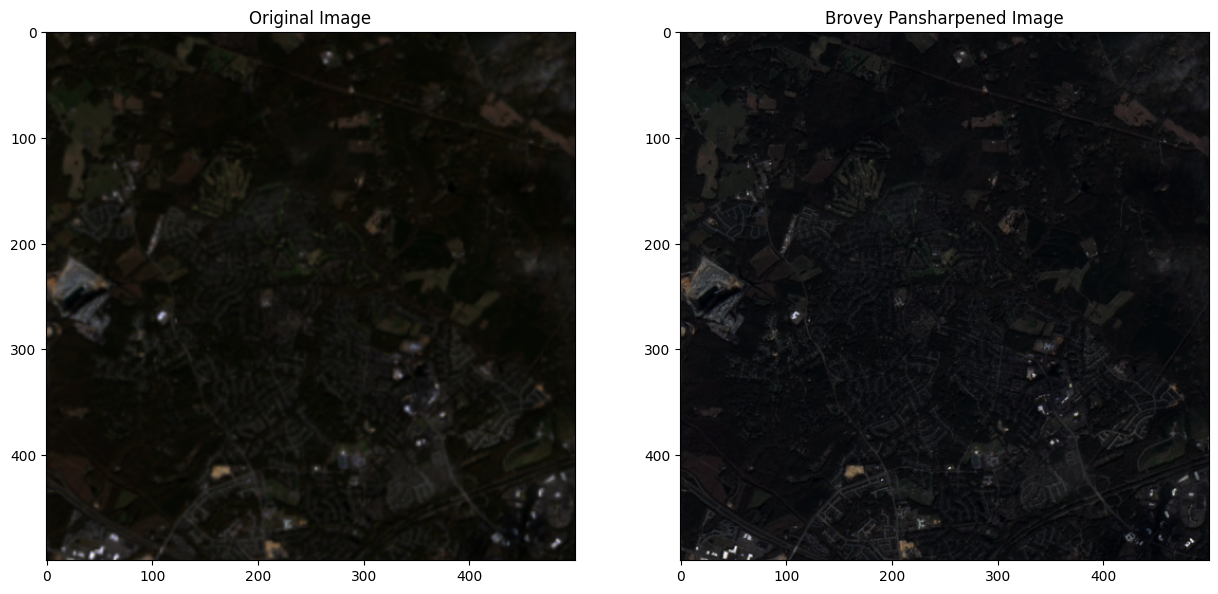

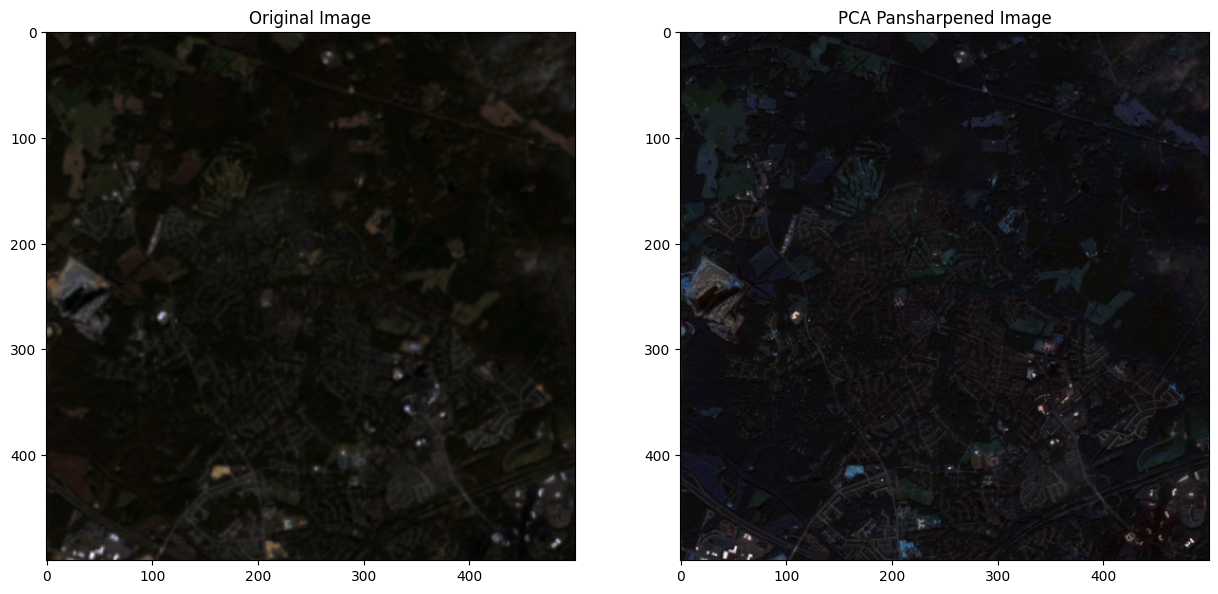

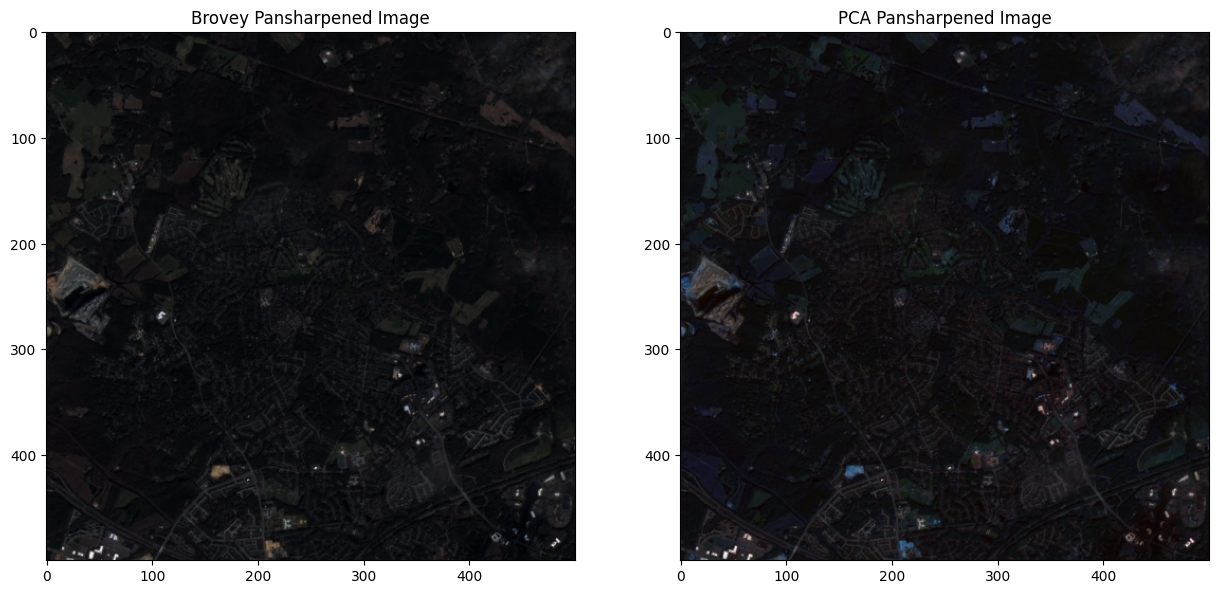

In [ ]:
# Read the resampled TOA reflectance data
ds_B2_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_resampled_band2_TOA.tif')
ds_B3_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_resampled_band3_TOA.tif')
ds_B4_TOA = gdal.Open('/content/drive/MyDrive/geog371shared/subsets/subset_resampled_band4_TOA.tif')
ds_pansharpened_brovey = gdal.Open('/content/drive/MyDrive/geog371shared/brovey_output/pansharpened_brovey_subset.tif')
ds_pansharpened_pca = gdal.Open('/content/drive/MyDrive/geog371shared/pca_output/pansharpened_pca_subset.tif')

# Access the pansharpened rgb bands
pansharpened_brovey_red = ds_pansharpened_brovey.GetRasterBand(3).ReadAsArray().astype(np.float32)
pansharpened_brovey_green = ds_pansharpened_brovey.GetRasterBand(2).ReadAsArray().astype(np.float32)
pansharpened_brovey_blue = ds_pansharpened_brovey.GetRasterBand(1).ReadAsArray().astype(np.float32)

pansharpened_pca_red = ds_pansharpened_pca.GetRasterBand(3).ReadAsArray().astype(np.float32)
pansharpened_pca_green = ds_pansharpened_pca.GetRasterBand(2).ReadAsArray().astype(np.float32)
pansharpened_pca_blue = ds_pansharpened_pca.GetRasterBand(1).ReadAsArray().astype(np.float32)

# Normalize the bands using min max scaling to make sure that we are comparing the images the same way
band2_norm = (band2 - band2.min()) / (band2.max() - band2.min())
band3_norm = (band3 - band3.min()) / (band3.max() - band3.min())
band4_norm = (band4 - band4.min()) / (band4.max() - band4.min())
pansharpened_brovey_red_norm = (pansharpened_brovey_red - pansharpened_brovey_red.min()) / (pansharpened_brovey_red.max() - pansharpened_brovey_red.min())
pansharpened_brovey_green_norm = (pansharpened_brovey_green - pansharpened_brovey_green.min()) / (pansharpened_brovey_green.max() - pansharpened_brovey_green.min())
pansharpened_brovey_blue_norm = (pansharpened_brovey_blue - pansharpened_brovey_blue.min()) / (pansharpened_brovey_blue.max() - pansharpened_brovey_blue.min())
pansharpened_pca_red_norm = (pansharpened_pca_red - pansharpened_pca_red.min()) / (pansharpened_pca_red.max() - pansharpened_pca_red.min())
pansharpened_pca_green_norm = (pansharpened_pca_green - pansharpened_pca_green.min()) / (pansharpened_pca_green.max() - pansharpened_pca_green.min())
pansharpened_pca_blue_norm = (pansharpened_pca_blue - pansharpened_pca_blue.min()) / (pansharpened_pca_blue.max() - pansharpened_pca_blue.min())

# Create RGB images for original and pansharpened images
original_rgb = np.dstack((band4_norm, band3_norm, band2_norm))
pansharpened_brovey = np.dstack((pansharpened_brovey_red_norm, pansharpened_brovey_green_norm, pansharpened_brovey_blue_norm))
pansharpened_pca = np.dstack((pansharpened_pca_red_norm, pansharpened_pca_green_norm, pansharpened_pca_blue_norm))

# Compare
# Original vs Brovey
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

axes[0].imshow(original_rgb)
axes[0].set_title('Original Image')

axes[1].imshow(pansharpened_brovey)
axes[1].set_title('Brovey Pansharpened Image')

plt.show()

# Original vs PCA
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

axes[0].imshow(original_rgb)
axes[0].set_title('Original Image')

axes[1].imshow(pansharpened_pca)
axes[1].set_title('PCA Pansharpened Image')

plt.show()

# Brovey vs PCA
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

axes[0].imshow(pansharpened_brovey)
axes[0].set_title('Brovey Pansharpened Image')

axes[1].imshow(pansharpened_pca)
axes[1].set_title('PCA Pansharpened Image')

plt.show()

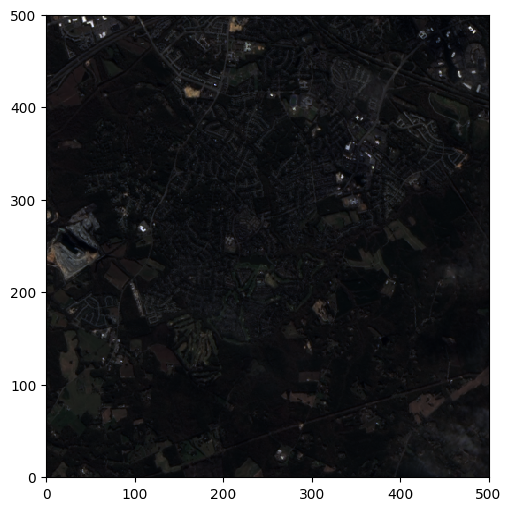

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(5, 5))
pcm = ax.pcolormesh(pansharpened_brovey, cmap='gray', vmax=1000000)
plt.show()